# 1. Import Libraries and Dataset

In [528]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [532]:
df = pd.read_csv(r"C:\Users\Mostafa\Downloads\netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# 2. EDA 

<h2><center> 2.1 Features </center></h2>
    1. Show_id : Unique ID of each show <br>
2. Type : Category of the show, Movie or Series <br>
3. Title : Name of the show <br>
4. Director : Name of the Director(s) of the show <br>
5. Cast : Name of the actors <br>
6. Country : Country where the Movie or Series was produced <br>
7. Date_added : When the show added to Netflix <br>
8. Release_Year : Actual Release year of the show <br>
9. Rating : TV Rating of the Show <br>
10. Duration : Total Duration in Minuter or Seasons <br>
11. Listed_in : Show's Genre <br>
12. Description : Description of the Show <br>

<h3><center> 2.2 Checking the NaN Values and Dtype </center></h3>


In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [538]:
all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
director,29.908028
country,9.435676
cast,9.367549
date_added,0.113546
rating,0.045418
duration,0.034064


<h3><center> Based on the Above Cell we found out </center></h3>

__1. All Data Types are Objects Excpet the Release Year__ <br><br>
__2. There are some missing Values in the following columns:__ <br>
__- Director__ <code>  29.9%  </code><br>
__- Country__ <code>   9,4%  </code><br>
__- Cast__ <code>   9.3%  </code><br>
__- Date Added__ <code>  0.11%  </code><br>
__- Rating__ <code>  0.04%  </code><br>
__- Duration__ <code>  0.03%  </code><br>

<h3><center> Let us now fill the NaNs with the appropriate values.</center></h3>

__- Director: We will fill it with None__<br>
__- Country: Will use the most redundant value which is United States__<br>
__- Cast: Fill it with None__<br>
__- Date Added: Use the most redundant value which is January 1, 2020__<br>
__- Rating: Use the most used value in the column which is TV-MA__<br>
__- Duration: will drop the 3 rows__<br>

In [543]:
df["country"] = df["country"].fillna(df['country'].mode()[0])
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['cast'] = df['cast'].fillna('None')
df['director'] = df['director'].fillna('None')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.drop([5541,5794,5813], axis=0, inplace=True)

#### We make two columns (Year and Month) form the show's added date.

In [544]:
df["year"]=pd.DatetimeIndex(df["date_added"]).year
df["month"]=pd.DatetimeIndex(df["date_added"]).month

In [545]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8804 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8804 non-null   object
 1   type          8804 non-null   object
 2   title         8804 non-null   object
 3   director      8804 non-null   object
 4   cast          8804 non-null   object
 5   country       8804 non-null   object
 6   date_added    8804 non-null   object
 7   release_year  8804 non-null   int64 
 8   rating        8804 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8804 non-null   object
 11  description   8804 non-null   object
 12  year          8804 non-null   int64 
 13  month         8804 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 1.0+ MB


In [138]:
df.duplicated().sum()

0

### Now, all of the dates are clean, with no duplicates detected.

### Let's create a new column to convert the rating and make it easier to visualize.

In [546]:
Ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
df["ratings_ages"]=df["rating"].replace(ratings_ages)

### We can observe that the content is spread among 69.9% of movies and 30.4% of series.

In [547]:
x=df["type"].value_counts().reset_index()
fig = px.pie(x,values="type",names="index")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Let's check which country has the most movies and television series.

In [548]:
countries = pd.crosstab(df['country'],'type').sort_values(by="type",ascending=False)[:10].reset_index()

In [549]:
countries

col_0,country,type
0,United States,3646
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199
5,Canada,181
6,Spain,145
7,France,124
8,Mexico,110
9,Egypt,106


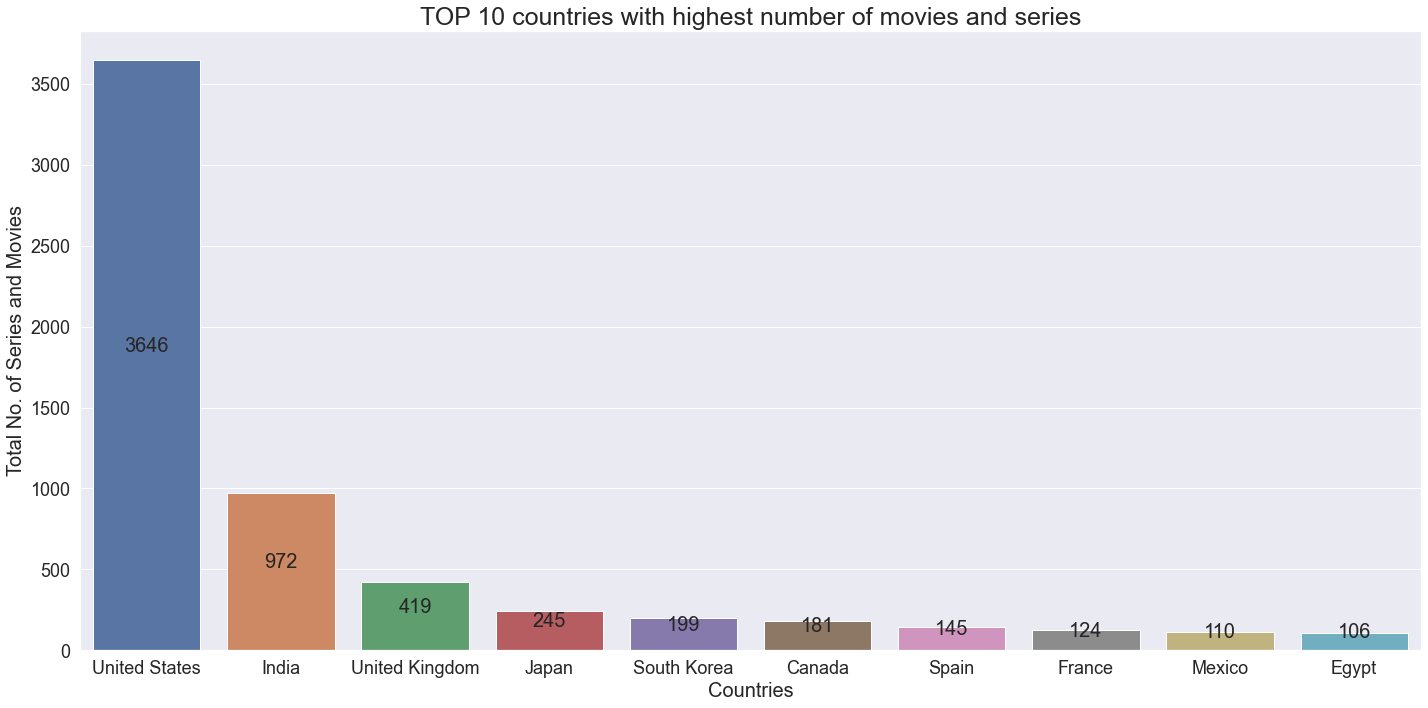

In [551]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=countries['country'], y = countries['type'])
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)

plt.title("TOP 10 countries with highest number of movies and series",fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Countries', fontsize=20)
plt.ylabel('Total No. of Series and Movies', fontsize=20)
plt.tight_layout()
plt.show()

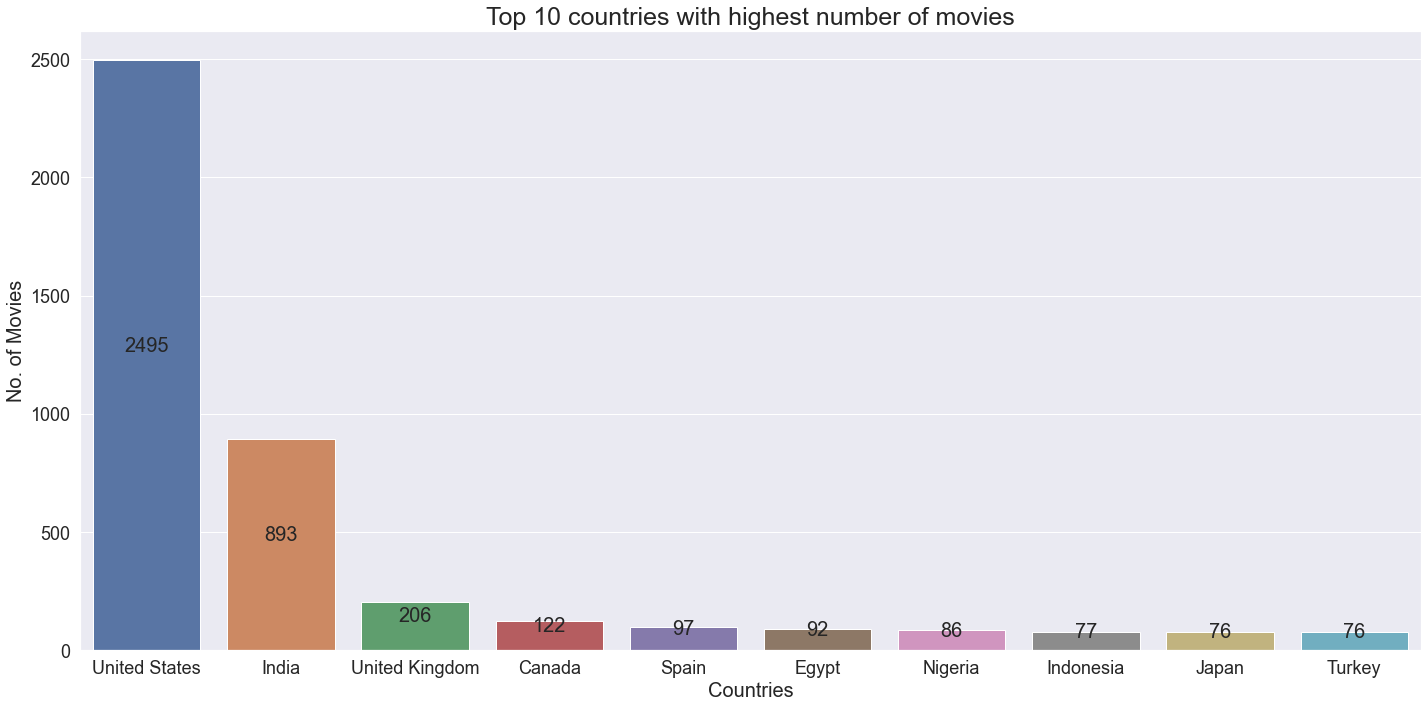

In [552]:
plt.figure(figsize=(20,10))
m = df[df['type']== 'Movie']
movies = m['country'].value_counts().reset_index()[:10]
ax = sns.barplot(x=movies['index'], y = movies['country'])
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)

plt.title("Top 10 countries with highest number of movies",fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Countries', fontsize=20)
plt.ylabel('No. of Movies', fontsize=20)
plt.tight_layout()
plt.show()

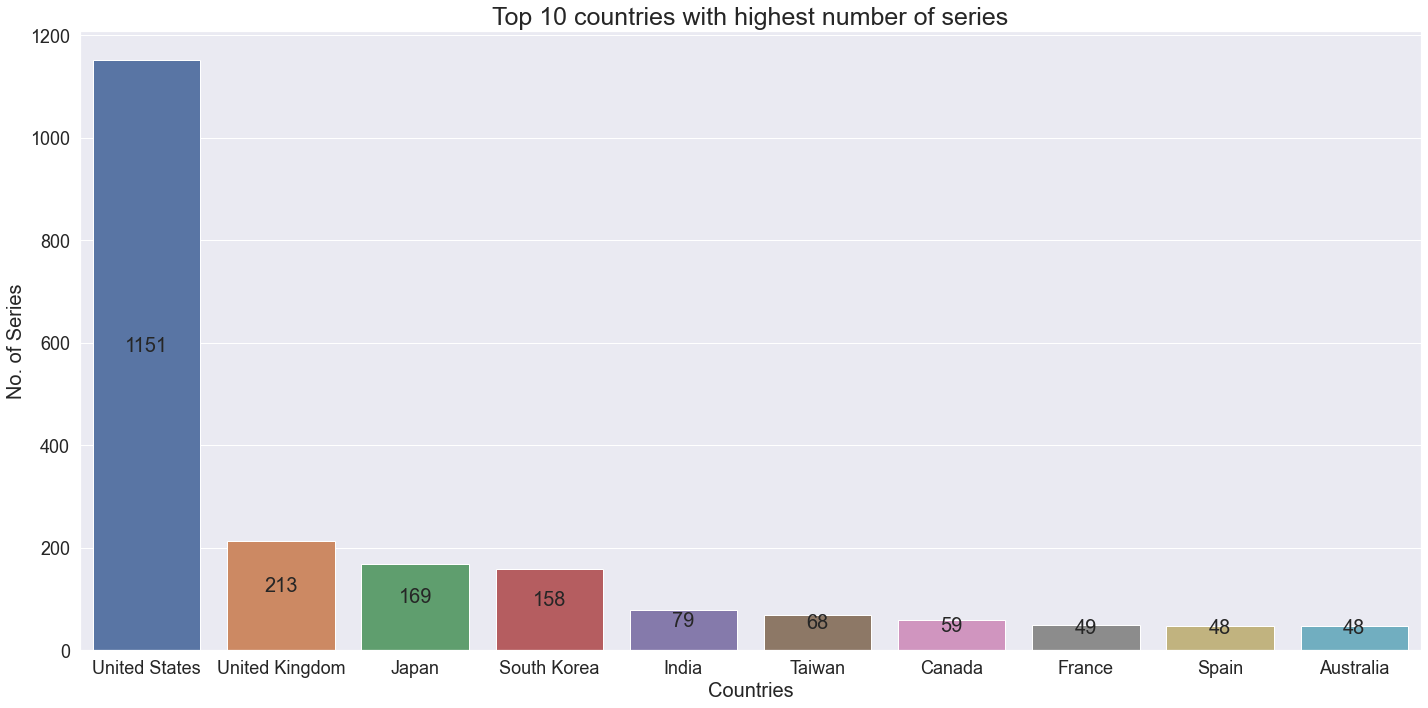

In [553]:
plt.figure(figsize=(20,10))
t = df[df['type']== 'TV Show']
series = t['country'].value_counts().reset_index()[:10]
ax = sns.barplot(x=series['index'],y=series['country'])

for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)

plt.title("Top 10 countries with highest number of series",fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Countries', fontsize=20)
plt.ylabel('No. of Series', fontsize=20)
plt.tight_layout()
plt.show()

### Based on the Above we can see that the United States has the most content accessible either Movies or Series.

### Let's find out which rating of the movie or series has the most production.

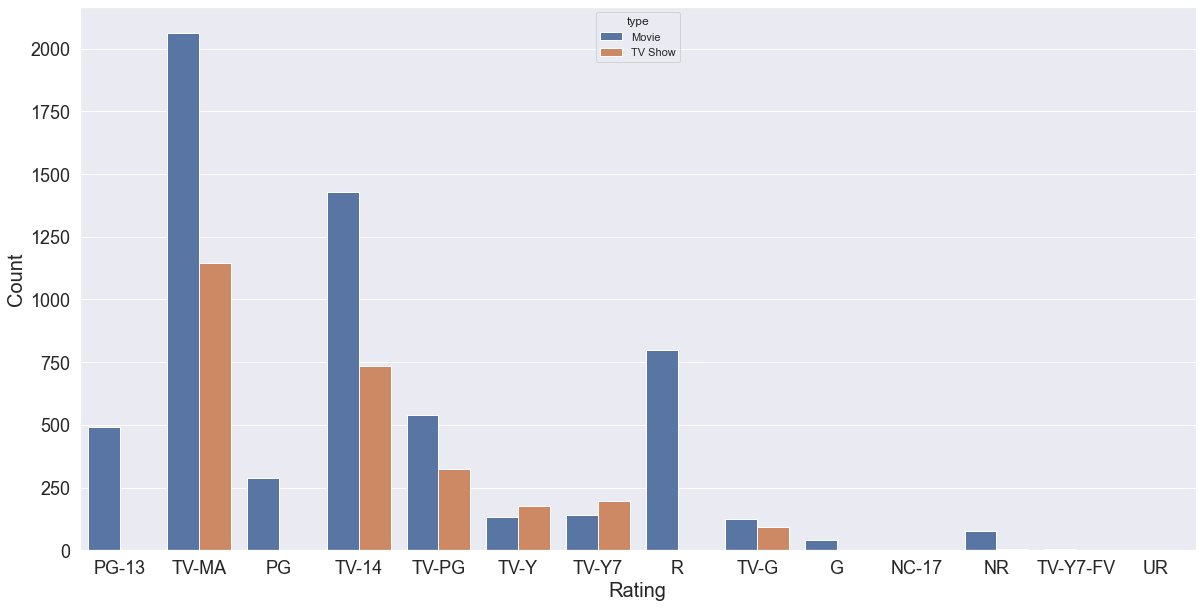

In [554]:
plt.figure(figsize = (20,10))
sns.countplot(x='rating',data = df,hue='type')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

In [565]:
y=df["ratings_ages"].value_counts().reset_index()
plt.figure(figsize=(20,10))
fig = px.pie(y,values="ratings_ages",names="index")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

<Figure size 1440x720 with 0 Axes>

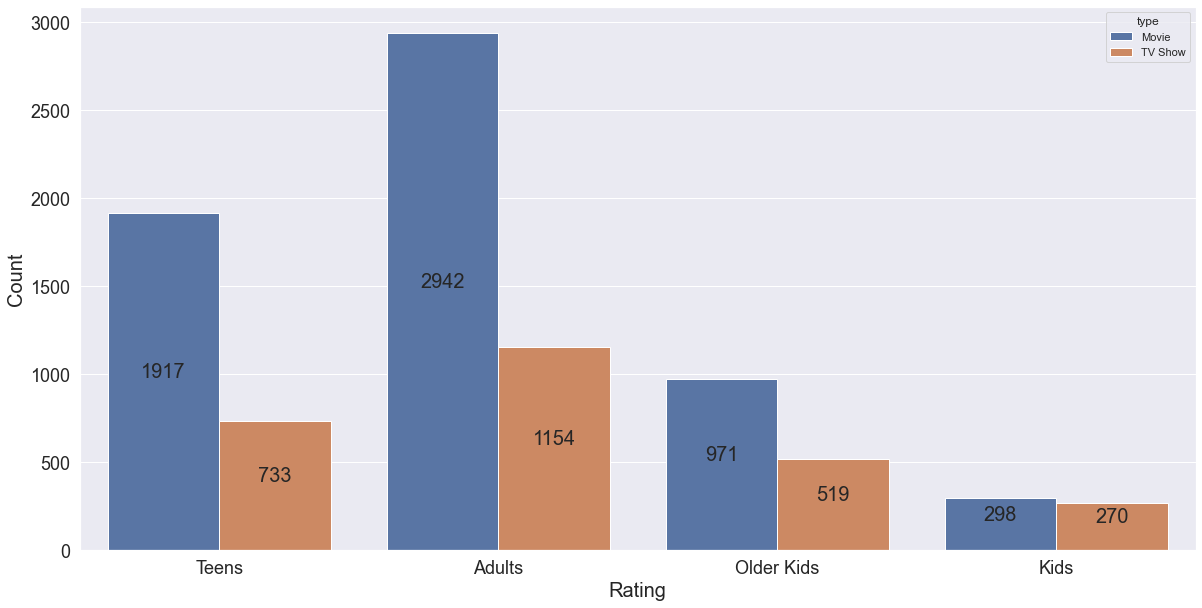

In [562]:
plt.figure(figsize = (20,10))
ax = sns.countplot(x='ratings_ages',data = df,hue='type')
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Rating', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

### We may conclude from the graphs above that Netflix productions are often aimed at adults.

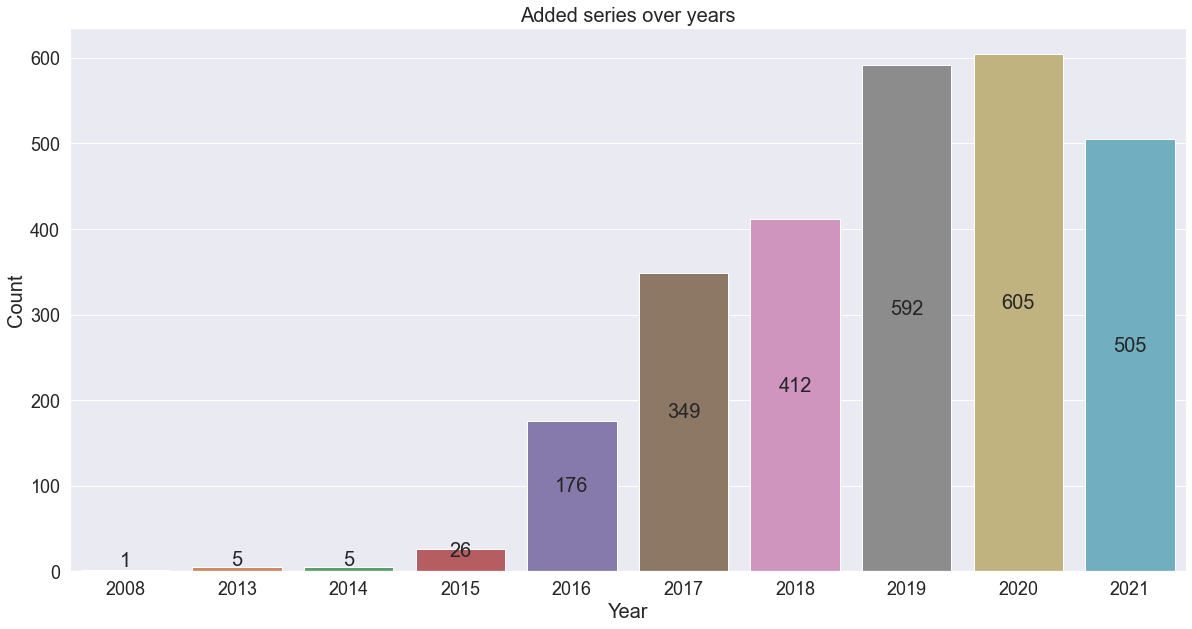

In [563]:
plt.figure(figsize=(20,10))
ax= sns.countplot(x= t["year"])
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)
plt.title("Added series over years",fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

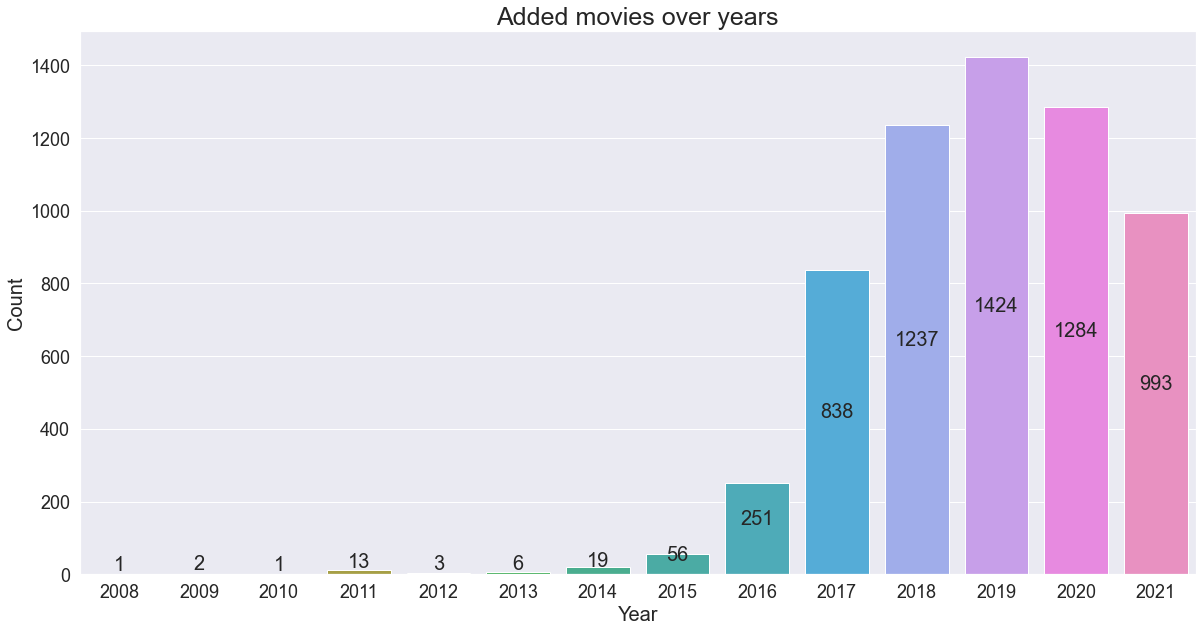

In [564]:
plt.figure(figsize=(20,10))
ax= sns.countplot(x= m["year"])
for rect in ax.patches:
    height = rect.get_height()
    ypos = rect.get_y() + height/2
    ax.text(rect.get_x() + rect.get_width()/2., ypos,
            '%d' % int(height), ha='center', va='bottom',fontsize = 20)
plt.title("Added movies over years",fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.show()

### In The Year 2020, Netflix added 605 Series on the platform while in 2019 it was 592. 
### In The Year 2019, Netflix added 1424 new Movies.

## Now let's check for the top Genres

In [566]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
key_value = {}  # key - genre, value - number of content 
for g1 in df['genre']:
    for g2 in g1:
        if g2 not in key_value:
            key_value[g2] = 0
        key_value[g2] += 1
        
df_upd = pd.DataFrame(data=list(zip(key_value.keys(), key_value.values())),
                      columns=['genre', 'Number of content']).sort_values('Number of content',
                                                                          ascending=False)[0:20]

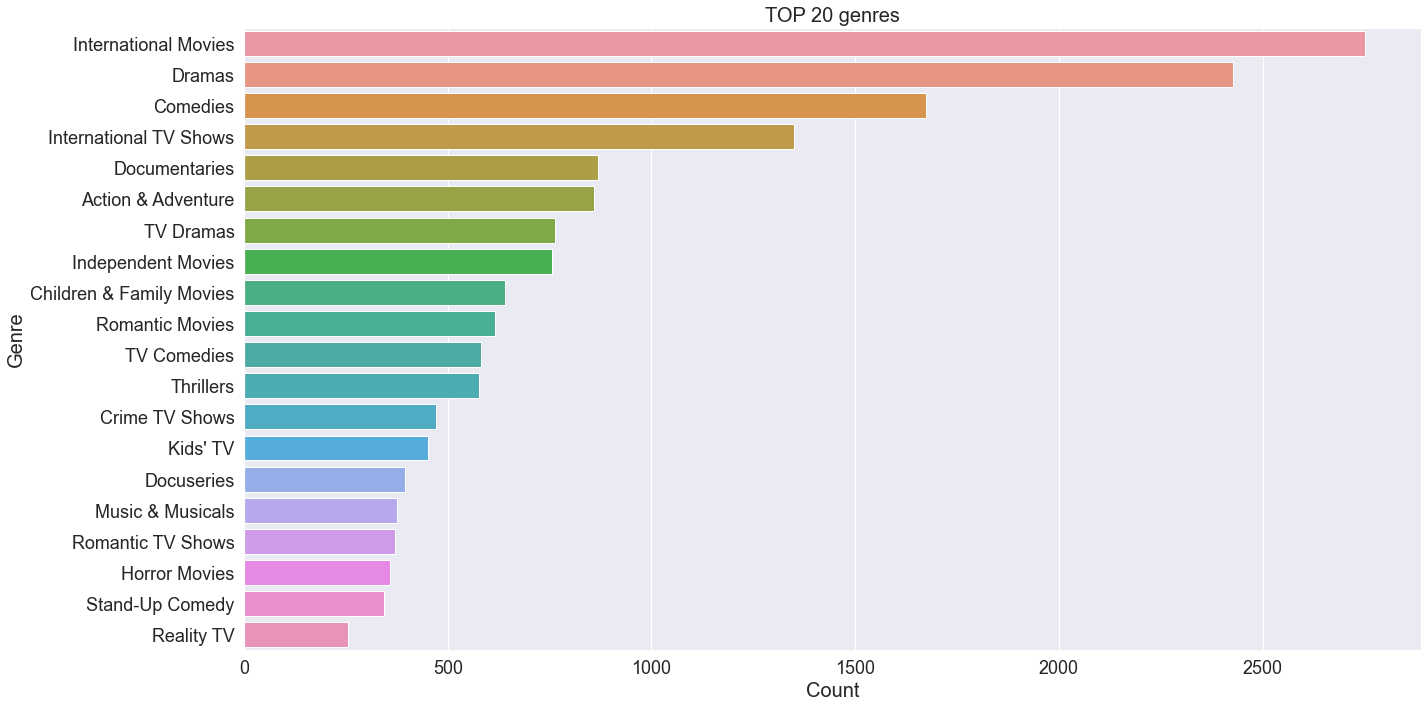

In [567]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=df_upd['genre'], x = df_upd['Number of content'],orient = 'h')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("TOP 20 genres",fontsize=20)
plt.xlabel('Count', fontsize=20)
plt.ylabel('Genre', fontsize=20)
plt.tight_layout()
plt.show()

### As a result, the top five are international films and television series, dramas, comedies, and documentaries, and these genres can be aimed at any country in the globe.

In [568]:
m['duration'] = m['duration'].str.replace(' min','')
m['duration'] = m['duration'].apply(lambda x: float(x))

<ipython-input-568-447e03c57365>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-568-447e03c57365>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



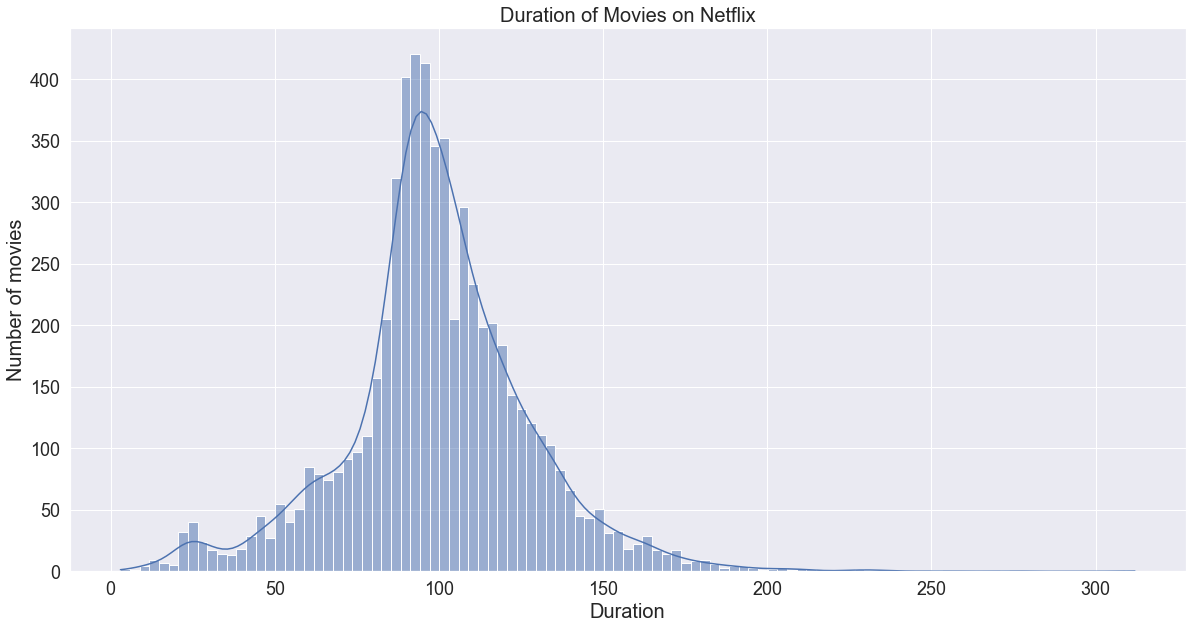

In [569]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
sns.histplot(data = m['duration'], kde=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Duration of Movies on Netflix", fontsize =20)
plt.xlabel('Duration', fontsize=20)
plt.ylabel('Number of movies', fontsize=20)
plt.show()

### The average length of the films is 90-110 minutes.

In [570]:
df['countries'] = df['country'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
key_value = {}  # key - genre, value - number of content 
for g1 in df['countries']:
    for g2 in g1:
        if g2 not in key_value:
            key_value[g2] = 0
        key_value[g2] += 1
        
df_con = pd.DataFrame(data=list(zip(key_value.keys(), key_value.values())),
                      columns=['Country', 'Number of content']).sort_values('Number of content',
                                                                          ascending=False)[:50]

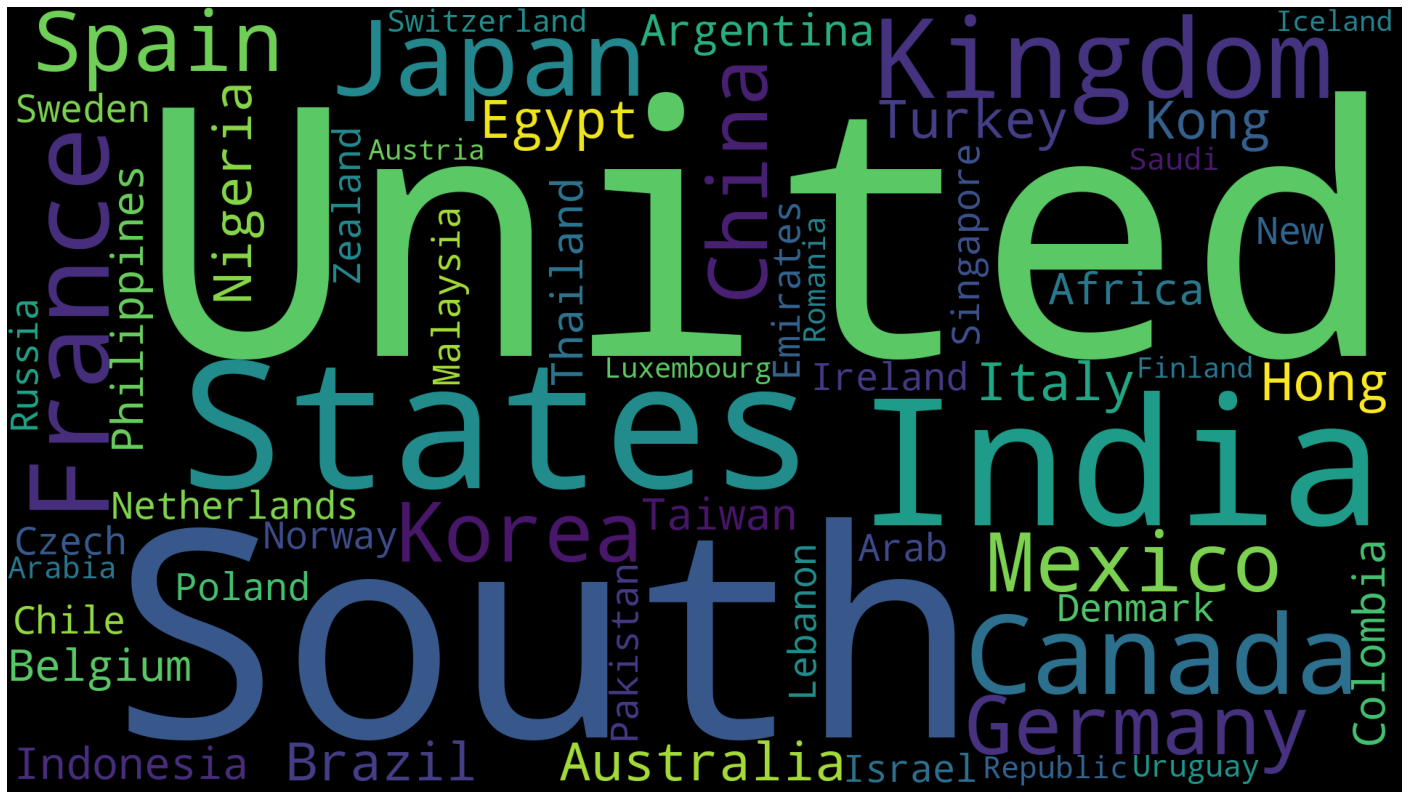

In [572]:
from wordcloud import WordCloud

text = " ".join(cat for cat in df_con.Country)

plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='Black',
                          width=1920,
                          height=1080
                         ).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 3. Recommendation System:

In [573]:
df['text'] = df['title'] + ' '+df['director'] + ' '+ df['cast']+ ' ' +df['listed_in'] + ' '+df['description']

In [574]:
df.text[0]

'Dick Johnson Is Dead Kirsten Johnson None Documentaries As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.'

In [575]:
def preprocess(text):
    text = re.sub('[^A-z]', ' ', text)
    stop_words = set(stopwords.words('english')) #removing stopwords
    word_tokens = word_tokenize(text)  
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    filtered_sentence = []  
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(lemmatizer.lemmatize(w))
    filtered = ' '.join([x for x in filtered_sentence])
    return filtered.lower().strip()

In [576]:
df['text'] = df['text'].apply(lambda x : preprocess(x))

In [577]:
df.text[0]

'dick johnson is dead kirsten johnson none documentaries as father nears end life filmmaker kirsten johnson stage death inventive comical way help face inevitable'

In [578]:
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(df['text'])

In [579]:
similarity_matrix = cosine_similarity(text_features)    

In [580]:
def get_recommendation(movie_name):
        movie_index = df[df['title'] == movie_name].index
        movie_similarity = similarity_matrix[movie_index]
        movie_data = pd.DataFrame({'cosine_similarity':movie_similarity[0], 'index':np.arange(8804)})
        movie_data = movie_data.sort_values(by = 'cosine_similarity', ascending = False)
        movie_ids = movie_data['index'][1:10]
        movie_sim = movie_data['cosine_similarity'][1:10]
        recommendation_movies = list()
        simalrity = []
        for temp in movie_ids:
            movie = df['title'][temp]
            sim = movie_data['cosine_similarity'][temp]
            recommendation_movies.append(movie)
            simalrity.append(sim)
            
        res = {}
        for key in recommendation_movies:
            for value in simalrity:
                res[key] = value
                simalrity.remove(value)
                break  
        return  res
    

In [581]:
get_recommendation("Unsolved Mysteries")

{'A Perfect Crime': 0.20850193256100033,
 'Sex Doll': 0.20661885295080148,
 'The Disappearance of Madeleine McCann': 0.19742793334542777,
 'I AM A KILLER': 0.19573701388666073,
 'The Confession Tapes': 0.18865111972394627,
 'Code Name: The Cleaner': 0.1821825200338896,
 'The Keepers': 0.17446682897490629,
 'Disappearance': 0.1725952928350762,
 'The Staircase': 0.17145970227242785}

In [582]:
get_recommendation("The Umbrella Academy")

{'The Free Man': 0.20121372459577325,
 'Shrek the Musical': 0.1555561563541323,
 'The Staircase': 0.15143271396105948,
 'Biohackers': 0.14967961448951553,
 'Warrior Nun': 0.14550994525519687,
 'The Dragon Prince': 0.13872981432267634,
 'Unsolved Mysteries': 0.13848851485574185,
 'The Mole': 0.13768532019733534,
 'The OA': 0.13655496231048664}

In [583]:
get_recommendation("Narcos")

{'Wild District': 0.1901340407938741,
 'Narcos: Mexico': 0.18986178747582025,
 'Ek Hasina Thi': 0.18001044957323603,
 'El final del paraíso': 0.15337207693032756,
 'The Great Heist': 0.15003938189382687,
 'Dries': 0.14533601208308597,
 'La Femme': 0.1355676701171273,
 'Miracle': 0.13262143295321416,
 'Sin senos sí hay paraíso': 0.13237694107350972}